In [ ]:
import matplotlib.pyplot as plt

# from gridworlds.grid_env import GridEnvironment
from src.Generalist.generalist_meta_env import Generalist_MetaEpisodeEnv
from src.Generalist.draw_gridworld import draw_policy

# import gymnasium as gym
from stable_baselines3 import PPO, A2C
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.utils import set_random_seed

#stablebaselines feature extractor
from src.Generalist.feature_extractor import Custom_Flatten

#For evaluation
from src.Generalist.evals_utils import average_evals

# Load Gridworlds

In [3]:
#Load the gridworlds
from classes import Object
import pickle

with open('src/world_builder/worlds/master_set_train.pkl','rb') as f:
    train_gridworlds = pickle.load(f)
print(f'{len(train_gridworlds)} train gridworlds loaded')  
for grid in train_gridworlds:
    grid.early_stopping = False   

with open('src/world_builder/worlds/master_set_val.pkl','rb') as f:
    val_gridworlds = pickle.load(f)
print(f'{len(val_gridworlds)} val gridworlds loaded')  
for grid in val_gridworlds:
    grid.early_stopping = False   

with open('src/world_builder/worlds/master_set_test.pkl','rb') as f:
    test_gridworlds = pickle.load(f)
print(f'{len(test_gridworlds)} test gridworlds loaded')  
for grid in test_gridworlds:
    grid.early_stopping = False       

976 train gridworlds loaded
96 val gridworlds loaded
200 test gridworlds loaded


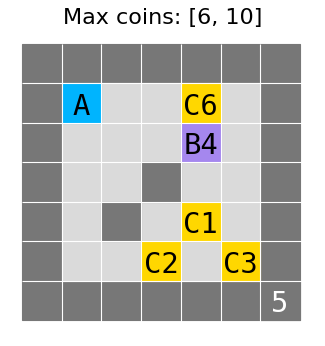

In [5]:
# VISUALISE GRIDWORLD HERE:

# ========================================
env = test_gridworlds[0] #change index to change gridworld
# ========================================

env.reset()
env.render()
plt.title(f'Max coins: {env.max_coins}', fontsize=20)
plt.show()

# Training

In [6]:
## DREST CONFIG ##
#IF USING DREST CONFIG set self.m_values = self.env.max_coins in lines 24 and 48 in src/Generalist/generalist_meta_env.py
config={
    "env_list": "976",     
    "test_env_list": "200",  
    "lambda_factor": 0.9,
    "meta_ep_size": 32,
    "hidden_layer_depth": 512,
    "num_hidden_layers": 3,
    "ent_coef": 0.02,
    "learning_rate": 0.000001,
    "total_timesteps": 500000,
    "clip_range": 0.2,
    "n_steps_ppo": 8192,
    "batch_size": 64,
    "vf_coef": 0.55,
    "timesteps_per_run":1000000
    }

In [7]:
## PICK ENVIRONMENT
train_env_list = train_gridworlds           #MANUALLY CHANGE
test_env_list = test_gridworlds              #MANUALLY CHANGE

hld = config["hidden_layer_depth"]
num_layers = config["num_hidden_layers"]

def net_arch(hidden_layer_depth, num_hidden_layers):
    net_arch_list = []
    for n in range(num_hidden_layers):
          net_arch_list.append(hidden_layer_depth)
    return net_arch_list      

net_arch_list = net_arch(hld, num_layers)

policy_kwargs = dict(features_extractor_class=Custom_Flatten, 
                     features_extractor_kwargs=dict(features_dim=250),
                     net_arch=dict(pi=net_arch_list, 
                                   vf=net_arch_list))

#Number of vectorised environments
num_cpu=3

#Set-up for vectorised environments
def make_env(rank, seed=0):
        """
        Utility function for multiprocessed env.

        :param env_id: (str) the environment ID
        :param seed: (int) the inital seed for RNG
        :param rank: (int) index of the subprocess
        """

        def _init():
            env = Generalist_MetaEpisodeEnv(
                    train_env_list, 
                    meta_ep_size=config["meta_ep_size"],
                    lambda_factor=config["lambda_factor"],
                )
            # use a seed for reproducibility
            # Important: use a different seed for each environment
            # otherwise they would generate the same experiences
            env.reset(seed=seed + rank)
            return env

        set_random_seed(seed)
        return _init


def vec_learning_run(model, timesteps):

    env = SubprocVecEnv([make_env(i) for i in range(num_cpu)],start_method="fork")

    model.set_env(env)

    model.learn(total_timesteps=timesteps) 

    return model


def vec_learning(train_env_list,timesteps_per_run, total_timesteps):

    steps_count = 0
    best_test_weighted_average = 0
    best_model_step = 0

    env = SubprocVecEnv([make_env(i) for i in range(num_cpu)],start_method="fork")

    # Create the PPO model with the custom architecture
    model = PPO("MlpPolicy",                                  #MAUALLY CHANGE with feature_extractor_class
                env,                                      #Change for vectorised Envs
                verbose=1,
                ent_coef=config["ent_coef"],
                learning_rate= config["learning_rate"],
                clip_range=config["clip_range"],
                n_steps=config["n_steps_ppo"],
                batch_size=config["batch_size"],
                vf_coef=config["vf_coef"],
                policy_kwargs=policy_kwargs,           #MANUALLY CHANGE
                )
    
    while steps_count < total_timesteps:

        model = vec_learning_run(model, timesteps_per_run)
        train_av_traj_ratio, train_av_usefulness, train_av_entropy = average_evals(train_env_list,model)
        test_av_ratio, test_av_usefulness, test_av_entropy = average_evals(test_env_list,model)
        test_weighted_average = 0.7 * test_av_usefulness + 0.3 * test_av_entropy
        steps_count += timesteps_per_run
        print(f'Step count: {steps_count}')
        print(f'Average Usefulness: {train_av_usefulness}')
        print(f'Average NEUTRALITY: {train_av_entropy}')
        print(f'Weighted Average: {train_av_traj_ratio}')

        if test_weighted_average > best_test_weighted_average:
             best_model_step = steps_count - timesteps_per_run
             best_test_weighted_average = test_weighted_average

    return model, best_model_step  

model, best_model_step = vec_learning(train_env_list, config['timesteps_per_run'], config['total_timesteps'])

Using cpu device
------------------------------
| time/              |       |
|    fps             | 2911  |
|    iterations      | 1     |
|    time_elapsed    | 8     |
|    total_timesteps | 24576 |
------------------------------
-------------------------------------------
| time/                   |               |
|    fps                  | 1553          |
|    iterations           | 2             |
|    time_elapsed         | 31            |
|    total_timesteps      | 49152         |
| train/                  |               |
|    approx_kl            | 0.00014181258 |
|    clip_fraction        | 0             |
|    clip_range           | 0.2           |
|    entropy_loss         | -1.39         |
|    explained_variance   | 0.15893596    |
|    learning_rate        | 1e-06         |
|    loss                 | 0.156         |
|    n_updates            | 10            |
|    policy_gradient_loss | -0.000662     |
|    value_loss           | 0.603         |
------------------

# Train Scores

In [8]:
train_av_traj, train_av_usefulness, train_av_entropy = average_evals(train_env_list,model)

print('Average evals for train data')
print(f'Average Trajectory Ratio:{"{:.3f}".format(train_av_traj)}')
print(f'Average USEFULNESS:{train_av_usefulness}')
print(f'Average NEUTRALITY:{train_av_entropy}')
print('\n')

Average evals for train data
Average Trajectory Ratio:14.342
Average USEFULNESS:0.37537378181128206
Average NEUTRALITY:0.659433085823456




# Test Scores

In [ ]:
test_av_traj, test_av_usefulness, test_av_entropy = average_evals(test_env_list,model)

print('Average evals for test data')
print(f'Average Trajectory Ratio:{"{:.3f}".format(test_av_traj)}')
print(f'Average USEFULNESS:{test_av_usefulness}')
print(f'Average NEUTRALITY:{test_av_entropy}')
print('\n')

# Draw Policy Diagrams

In [ ]:
for env in test_gridworlds:                                        # MANUALLY CHANGE
    draw_policy(env, model)